In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io
import scipy.signal
import time
from noise_buffer_overlay import NoiseOverlay
from datetime import datetime

In [81]:
ol = NoiseOverlay(bitfile_name='hw/top_biastini_32bitDDS_noise_buffer_ILA.bit',download=True,dbg=True,plot=False)

loading bitfile hw/top_biastini_32bitDDS_noise_buffer_ILA.bit
loaded bitstream
set clocks


In [83]:
ol.set_dac_scale_factor(0.5,0)
ol.set_dac_scale_factor(0.5,1)
ol.set_dac_atten_dB(18,0)
ol.set_dac_atten_dB(18,1)
ol.set_vga_atten_dB(18,0)
ol.set_vga_atten_dB(18,1)
ol.set_freq_hz(950e3,0)
ol.set_freq_hz(950e3,1)

setting dac_prescale scale_factor to 0.5 (08000)
setting dac_prescale scale_factor to 0.5 (08000)
setting cos_scale to 3 (18dB attenuation)
setting cos_scale to 3 (18dB attenuation)
setting vga attenuation to 18dB
packet = 0x212
setting vga attenuation to 18dB
packet = 0x10212
setting pinc to 996147 (9.500e+05Hz)
setting pinc to 996147 (9.500e+05Hz)


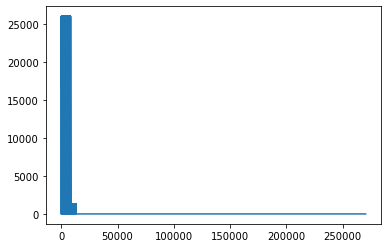

In [88]:
# configure noise buffer and capture some data
# configuration packet is 35 bits, so we need two words
# {mode, start, stop, threshold_high, threshold_low}
# always capture start: {0, 1, 0, 16'b0, 16'b1}
# always capture stop: {0, 0, 1, 16'b0, 16'b1}
start_pkt = [0x00ff, 0x2]
stop_pkt = [0x00ff, 0x1]
ol.noise_buffer.send_tx_pkt(start_pkt)
time.sleep(0.01)
ol.noise_buffer.send_tx_pkt(stop_pkt)
ol.dma()
plt.plot(ol.dma_buffer)

In [89]:
ch0 = []
ch1 = []
for samp in ol.dma_buffer[:1000]:
    if samp & 0x4:
        ch1.append(samp & 0xf8)
    else:
        ch0.append(samp & 0xf8)
data = np.array([ch0, ch1])

/tmp/ipykernel_1330/1042108181.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([ch0, ch1])


In [71]:
print(len(ch0))
print(len(ch1))

750
250


In [75]:
print([f'{(i & 0x7):03b}' for i in ol.dma_buffer[:32]])

['010', '010', '001', '000', '000', '100', '100', '000', '010', '010', '001', '000', '000', '100', '100', '000', '010', '010', '001', '000', '000', '100', '100', '000', '010', '010', '001', '000', '000', '100', '100', '000']


In [105]:
print([f'{i:04x}' for i in ol.dma_buffer[8184:8192]])
print([f'{i:04x}' for i in ol.dma_buffer[8192:8200]])
#008603fa002603aa00060332002602aa

['0000', '6594', '40dc', '0006', '0000', '59de', '40dc', '0006']
['02aa', '0026', '0332', '0006', '03aa', '0026', '03fa', '0086']


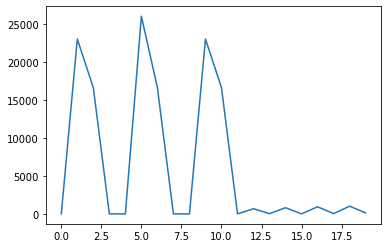

In [103]:
plt.plot(ol.dma_buffer[8180:8200])